## Retrieval Reader Architecture

In [2]:
import datasets

In [3]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

### 1. Loading the dataset from datasets 

In [4]:
from datasets import load_dataset

subjqa = load_dataset("subjqa" , name="electronics")

In [5]:
print(subjqa["train"]["answers"][3])

{'text': ['the best of all of them'], 'answer_start': [1609], 'answer_subj_level': [1], 'ans_subj_score': [0.30000001192092896], 'is_ans_subjective': [False]}


In [6]:
subjqa

DatasetDict({
    train: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 1295
    })
    test: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 358
    })
    validation: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 255
    })
})

In [7]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [8]:
qa_cols = ["title", "question", "answers.text",
           "answers.answer_start", "context"]

sample_df = dfs["train"][qa_cols].sample(10, random_state=42)
sample_df.head(10)

,title,question,answers.text,answers.answer_start,context
834,B005HMO6A6,How do you like the keyboard?,[],[],The good*Overall design is elegant*Quality fee...
327,B002C7481G,How is the processor?,[],[],So I have had my iPad now for about a month. T...
839,B005HMO6A6,Does this have the ability to use batteries?,[],[],-Love this product! I have tried other wirele...
1121,B009A5204K,What is the sound quality?,[],[],"One may look at me strangely, friends may call..."
976,B0075SUK14,How is the zoom?,[],[],We just returned from a trip overseas and brou...
536,B003LR7ME6,How do I get to the port?,[],[],Love this case. With the exception of the exp...
477,B003ELYQGG,How clear was the sound?,"[Although the sound is nice and neutral, sound...","[0, 13]","Although the sound is nice and neutral, the ba..."
1078,B008ABOJKS,How do you like the performance?,"[the performance is excellent, I'd like to imp...","[225, 1989]",asuswrt is by far the best firmware for this r...
889,B006W8U2MU,How did you like the performance?,[],[],This thing is so tiny it is hard to believe it...
76,B0002L5R78,What do you think about price?,[],[],"So I ordered 3, and two work perfectly fine. O..."


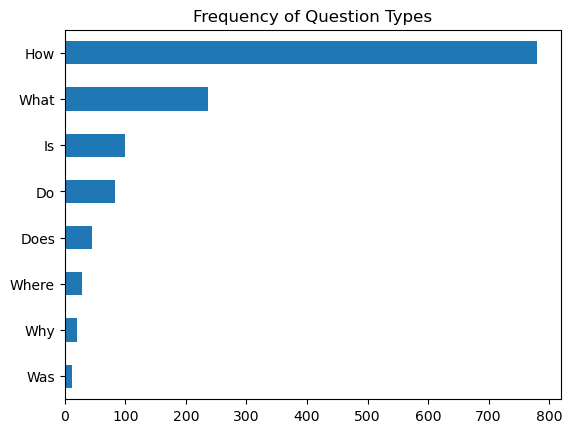

In [9]:
import matplotlib.pyplot as plt

counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [10]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=10)['question']):
        print(question)

How was the signal?
How is the connection of the cables?
How was the power supply?
What are the sizes of the lens?
What is the performance of the product?
What is earphone?
Is the cable expensive?
Is this phome comes with a charger?
Is the bass sound the deepest ?


### 2. Extracting Answers from Text

In [11]:
#Tokenizing text for Question Answering
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [12]:
question = "How much music can this hold?"
context = """ An MP3 is about 1 MB/minute, so about 6000 hours depending on file size."""

inputs = tokenizer(question, context, return_tensors="pt")

In [13]:
#!huggingface-cli scan-cache

In [14]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


In [15]:
import torch

from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)

print(outputs)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [16]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [17]:
print(f"Inputs IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Inputs IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


In [18]:
import torch

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)

print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


In [19]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

2024-03-27 14:39:29.411233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/oscar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:326: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2651623785495758, 'start': 39, 'end': 49, 'answer': '6000 hours'},
 {'score': 0.22082938253879547,
  'start': 17,
  'end': 49,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253461450338364,
  'start': 17,
  'end': 28,
  'answer': '1 MB/minute'}]

In [20]:
pipe(question = "Why is there no data?", context=context, 
    handle_impossible_answer=True)

{'score': 0.9068410992622375, 'start': 0, 'end': 0, 'answer': ''}

### Dealing with long passages

In [21]:
example = dfs["train"].iloc[0][["question", "context"]]

tokenized_example = tokenizer(example["question"], example["context"],
                              return_overflowing_tokens=True, max_length=100,
                              stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [22]:
for idx , window in enumerate(tokenized_example["input_ids"]):
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



In [23]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



### Using Haystack to Bulid a QA Pipeline

### Retriever Reader Architecture

In [24]:
!ls -la

total 623008
drwxr-xr-x@ 12 macbook  staff        384 Mar 27 11:35 .
drwxr-xr-x@ 22 macbook  staff        704 Mar 27 11:25 ..
drwxr-xr-x@ 12 macbook  staff        384 Mar 21 22:50 .git
drwxr-xr-x@  6 macbook  staff        192 Mar 26 16:36 .ipynb_checkpoints
-rw-r--r--@  1 macbook  staff     311493 Mar 21 12:37 27_First_RAG_Pipeline.ipynb
-rw-r--r--   1 macbook  staff       7761 Mar 21 23:44 HuggingFaceLLM.ipynb
-rw-r--r--   1 macbook  staff       3526 Mar 26 22:28 LangChainRAG1.ipynb
-rw-r--r--   1 macbook  staff         14 Mar 11 22:31 README.md
-rw-r--r--   1 macbook  staff     109487 Mar 27 14:41 Retriever_Reader_QA_System.ipynb
drwxr-xr-x@ 13 macbook  staff        416 Mar 27 11:35 elasticsearch-7.17.19
-rw-r--r--   1 macbook  staff  318532606 Mar 26 12:27 elasticsearch-7.17.19-darwin-x86_64.tar.gz
-rw-r--r--   1 macbook  staff        173 Mar 26 12:27 elasticsearch-7.17.19-darwin-x86_64.tar.gz.sha512


In [25]:
!ls

27_First_RAG_Pipeline.ipynb
HuggingFaceLLM.ipynb
LangChainRAG1.ipynb
README.md
Retriever_Reader_QA_System.ipynb
elasticsearch-7.17.19
elasticsearch-7.17.19-darwin-x86_64.tar.gz
elasticsearch-7.17.19-darwin-x86_64.tar.gz.sha512


In [26]:
import os 
from subprocess import Popen, PIPE , STDOUT

# Run ElasticSearch as a background process 
#!chown -R daemon:daemon elasticsearch-7.17.18
#es_server = Popen(args=['elasticsearch-7.17.18/bin/elasticsearch'],
#                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))

# wait until Elasticsearch has started
#!sleep 30

In [27]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "MacBook-Pro-2.local",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "YlSSemUtSe6O8l_FNfAfGg",
  "version" : {
    "number" : "7.17.19",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "92f290e9537478f85ff3fe3ab39945c1a49a6c1a",
    "build_date" : "2024-03-21T14:34:38.216751500Z",
    "build_snapshot" : false,
    "lucene_version" : "8.11.3",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [28]:
#!pip install haystack-ai

In [29]:
!pip show haystack-ai 

Name: haystack-ai
Version: 2.0.0
Summary: LLM framework to build customizable, production-ready LLM applications. Connect components (models, vector DBs, file converters) to pipelines or agents that can interact with your data.
Home-page: 
Author: 
Author-email: "deepset.ai" <malte.pietsch@deepset.ai>
License: 
Location: /Users/oscar/opt/anaconda3/envs/llm-env/lib/python3.9/site-packages
Requires: boilerpy3, haystack-bm25, jinja2, lazy-imports, more-itertools, networkx, numpy, openai, pandas, posthog, python-dateutil, pyyaml, requests, tenacity, tqdm, typing-extensions
Required-by: elasticsearch-haystack


In [30]:
!pip show elasticsearch-haystack

Name: elasticsearch-haystack
Version: 0.3.0
Summary: Haystack 2.x Document Store for ElasticSearch
Home-page: 
Author: 
Author-email: Silvano Cerza <silvanocerza@gmail.com>
License: 
Location: /Users/oscar/opt/anaconda3/envs/llm-env/lib/python3.9/site-packages
Requires: elasticsearch, haystack-ai
Required-by: 


In [31]:
#!pip uninstall -y farm-haystack haystack-ai

In [43]:
#!pip uninstall -y haystack-ai

In [44]:
!pip install farm-haystack

  Using cached Events-0.5-py3-none-any.whl.metadata (3.9 kB)
  Using cached prompthub_py-4.0.0-py3-none-any.whl.metadata (2.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.2/150.2 kB 580.6 kB/s eta 0:00:001.2 MB/s eta 0:00:01
  Using cached quantulum3-0.9.0-py3-none-any.whl.metadata (14 kB)
  Using cached rank_bm25-0.2.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached requests_cache-0.9.8-py3-none-any.whl.metadata (8.7 kB)
  Using cached sseclient_py-1.8.0-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached transformers-4.37.2-py3-none-any.whl.metadata (129 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.9 MB/s eta 0:00:00
  Using cached cattrs-23.2.3-py3-none-any.whl.metadata (10 kB)
  Using cached url_normalize-1.4.3-py2.py3-none-any.whl.metadata (3.1 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.0 MB/s eta 0:00:00
  Using cached inflect-7.0.0-py3-none-any.whl.metadata (21 kB)
  Using cached num2words-0.5.13-py3-none-any.whl.metadata (12 k

In [33]:
#from haystack.document_store import ElasticsearchDocumentStore

# return the document embedding for later use with the dense retriever
#document_store = ElasticsearchDocumentStore(embedding_fields="embedding")

In [34]:
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore

document_store = ElasticsearchDocumentStore(embedding_fields="embedding", hosts = "http://localhost:9200")

ModuleNotFoundError: No module named 'haystack_integrations'

In [35]:
!huggingface-cli whoami

Oscar066


In [38]:
!huggingface-cli scan-cache

REPO ID REPO TYPE SIZE ON DISK NB FILES LAST_ACCESSED LAST_MODIFIED REFS LOCAL PATH 
------- --------- ------------ -------- ------------- ------------- ---- ---------- 

Done in 0.0s. Scanned 0 repo(s) for a total of 0.0.
Got 7 warning(s) while scanning. Use -vvv to print details.


In [39]:
from haystack import Document
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack.components.retrievers.elasticsearch import ElasticsearchBM25Retriever

document_store = ElasticsearchDocumentStore(hosts="http://localhost:9200")
retriever = ElasticsearchBM25Retriever(document_store=document_store)

# Add documents to DocumentStore
documents = [
    Document(text="My name is Carla and I live in Berlin"),
    Document(text="My name is Paul and I live in New York"),
    Document(text="My name is Silvano and I live in Matera"),
    Document(text="My name is Usagi Tsukino and I live in Tokyo"),
]
document_store.write_documents(documents)

result = retriever.run(query="Who lives in Berlin?")
for doc in result["documents"]:
    print(doc.content)

ModuleNotFoundError: No module named 'haystack.document_stores.elasticsearch'

In [5]:
from haystack.document_store import ElasticsearchDocumentStore

# Initialize ElasticsearchDocumentStore
document_store = ElasticsearchDocumentStore(host="localhost", username="", password="", index="document")

# Assuming `dfs` is a dictionary containing splits of DataFrame objects
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"text": row["context"],
             "meta": {"item_id": row["title"], "question_id": row["id"], "split": split}}
            for _, row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs, index="document")

print(f"Loaded {document_store.get_document_count()} documents")

# Initializing a retriever
from haystack.retriever.sparse import ElasticsearchRetriever

es_retriever = ElasticsearchRetriever(document_store=document_store)


PydanticSchemaGenerationError: Unable to generate pydantic-core schema for <class 'pandas.core.frame.DataFrame'>. Set `arbitrary_types_allowed=True` in the model_config to ignore this error or implement `__get_pydantic_core_schema__` on your type to fully support it.

If you got this error by calling handler(<some type>) within `__get_pydantic_core_schema__` then you likely need to call `handler.generate_schema(<some type>)` since we do not call `__get_pydantic_core_schema__` on `<some type>` otherwise to avoid infinite recursion.

For further information visit https://errors.pydantic.dev/2.6/u/schema-for-unknown-type

In [40]:
for split ,df in dfs.items():
    #Exclude duplicate reviews 
    docs = [{"text": row["context"],
             "meta":{"item_id": row["title"], "question_id": row["id"],
                     "split": split}}
            for _, row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs, index="document")

print(f"Loaded {document_store.get_document_count()} documents")

NameError: name 'document_store' is not defined

In [41]:
# initializing a retriever
from haystack.retriever.sparse import ElasticsearchRetriever

es_retriever = ElasticsearchRetriever(document_store=document_store)

ModuleNotFoundError: No module named 'haystack.retriever'

In [ ]:
# test 1 
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = es_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split": ["train"]})

In [ ]:
print(retrieved_docs[0])

In [ ]:
# initailizing the reader
from haystack.reader.farm import FARMReader

model_ckpt = "deepset/minlm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False, 
                    max_seq_len=max_seq_length, doc_stride=doc_stride,
                    return_no_answer=True)

In [ ]:
print(reader.predict_on_tests(question=question, texts=[context], top_k=1))

In [ ]:
# putting it all together

from haystack.pipeline import ExtractveQAPipeline

pipe = ExtractiveQAPipeline(reader, es_retriever)

In [ ]:
n_answers = 3
preds = pipe.run(query=query, top_k_retriever=3, top_k_reader=n_answers,
                 filters={"item_id": [item_id], "split": ["train"]})

print(f"Question: {preds['query']}\n")

In [7]:
for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx]['answer']}")
    print(f"Review snippet: ... {preds['answers'][idx]['context']}...")\
    print("\n\n")

SyntaxError: unexpected EOF while parsing (537696967.py, line 1)

### improving the QA pipeline 

In [2]:
class PipelineNode:
    def __init__(self):
        self.outgoing_edges = 1

    def run(self, **kwargs):
        return outputs, "outgoing_edge_name")

SyntaxError: unexpected EOF while parsing (1783873878.py, line 5)

In [ ]:
from haystack.pipeline import Pipeline
from haystack.eval import EvalDocuments

class EvalRetrieverPipeline:
    def __init__(self, retriever):
        self.retriever = retriever
        self.eval_retriever = EvalDocuments()
        pipe = Pipeline()
        pipe.add_node(components=self.retriever, name="ESRetriever",
                     inputs = ["Query"])
        pipe.add_node(components=self.eval_retriever, name="EvalRetriever",
                      inputs=["ESRetriever"])
        self.pipeline = pipe

pipe = EvalRetrieverPipeline(es_retriever)        

In [3]:
from haystack import Label 

labels = []

for i , rows in dfs["test"].iterrows():
    meta = {"item_id": row["title"], "question_id": row["id"]}
    if len(row["answers.text"]):  
        for answer in rows["answers.text"]:     
            label = Label(
                question = row["question"], answer=answer, id=i, origin=row["id"],
                meta=meta, is_correct=True, is_correct_document=True, no_aswer=False)
                labels.append(label)
    else:
        label = Label(
            question = row["question"], answer=answer, id=i, origin=row["id"],
            meta=meta, is_correct=True, is_correct_document=True, no_aswer=False)
            labels.append(label)  

SyntaxError: EOL while scanning string literal (592314957.py, line 5)

In [ ]:
print(labels[0])

In [ ]:
document_store.write_labels(labels, index="label")
print(f"""Loaded {document_store.get_label_count(index="label")} \ 
question-answering pairs""")

In [ ]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"])

print(len(labels_agg))

### Retrieval Augmented Generation Model 1

In [ ]:
from haystack.generator.transformers import RAGenerator

generator = RAGenerator(model_name_or_path="facebook/rag-token-nq",
                        embed_title=False, num_beams=5)

In [ ]:
from haystack.pipeline import GenerativeQAPipeline

pipe = GenerativeQAPipeline(generator=generator, retriever=dpr_retriever)

In [34]:
def generate_answers(query, top_k_generator=3):
    preds = pipe.run(query=query, top_k_generator=top_k_generator,
                     top_k_retriever=5, filters={"items_id": ["B0074BW614"]})
    print(f"Question: {preds['query']} \n")
    for idx in range(top_k_generator):
        print(f"Answer {idx+1}: {preds['answer'][idx]['answer']}")

SyntaxError: unexpected EOF while parsing (814093296.py, line 1)

In [ ]:
generate_answers(query)

In [ ]:
generate_answers("What is the main drawbacks?")